In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import Stemmer
import time

In [5]:
start_time = time.time()

stemmer = Stemmer.Stemmer('english')

df_train = pd.read_csv('input/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('input/test.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('input/product_descriptions.csv')
df_attr = pd.read_csv('input/attributes.csv')

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stemWord(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
df_all = pd.merge(df_all, df_attr, how='left', on='product_uid')
df_all['value'] = df_all['value'].fillna('').astype(str).map(lambda x: str_stemmer(x))

df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

# Apply TF-IDF including the 'value' column
tfidf_vectorizer = TfidfVectorizer(max_features=200)  # Increased features to accommodate 'value'
X_tfidf = tfidf_vectorizer.fit_transform(df_all['product_description'] + " " + df_all['value'])

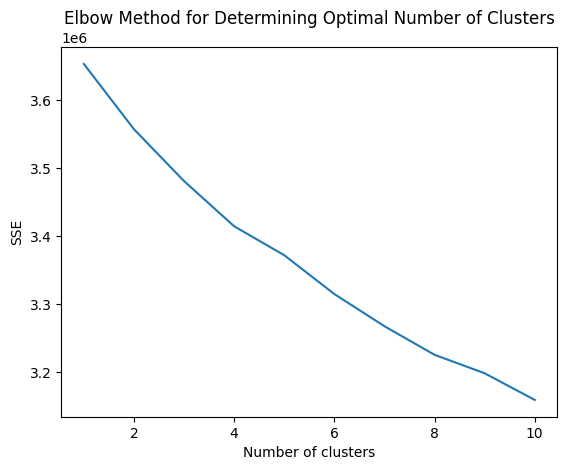

Data Types in the DataFrame:
id                       int64
product_uid              int64
product_title           object
search_term             object
relevance              float64
product_description     object
name                    object
value                   object
cluster                  int32
dtype: object
Non-numeric columns identified:
Index(['product_title', 'search_term', 'product_description', 'name', 'value'], dtype='object')


In [6]:

# Determine the optimal number of clusters using the Elbow Method
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    sse[k] = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Determining Optimal Number of Clusters")
plt.show()

# Apply clustering with the chosen number of clusters
optimal_clusters = 6  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_all['cluster'] = kmeans.fit_predict(X_tfidf)

# Inspecting data types
print("Data Types in the DataFrame:")
print(df_all.dtypes)

# Identifying non-numeric columns
non_numeric_columns = df_all.select_dtypes(include=['object']).columns
print("Non-numeric columns identified:")
print(non_numeric_columns)

# Visualize the clusters
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_tfidf.toarray())

plt.figure()
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df_all['cluster'], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
plt.title("Visualization of Clustering with PCA")
plt.show()

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)
df_all['product_info'] = df_all['search_term'] + "\t" + df_all['product_title'] + "\t" + df_all['product_description'] + "\t" + df_all['value']

df_all['word_in_title'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[2]))
df_all['word_in_value'] = df_all['product_info'].map(lambda x: str_common_word(x.split('\t')[3], x.split('\t')[3]))

df_all = df_all.drop(columns=non_numeric_columns)

# Re-check data types after dropping non-numeric columns
print("Data Types after dropping non-numeric columns:")
print(df_all.dtypes)



In [ ]:
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id', 'relevance'], axis=1).values

# Split the training data into training and validation sets (80-20 split)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train_split, y_train_split)

# Predictions on the validation set
y_val_pred = clf.predict(X_val_split)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
print("RMSE on validation set:", rmse)
print("Process finished --- %s seconds ---" % (time.time() - start_time))


ValueError: could not convert string to float: "travertin tile\tms intern chiaro brick 12 in. x 12 in. x 10 mm tumbl travertin mesh-mount mosaic tile\tchiaro brick tumbl travertin mosaic tile has small depress and crevic within each stone to project a rustic, old-world charm. predomin beig and cream, these 12 in. x 12 in. mesh-mount tile from ms intern exhibit random tone variat and coordin with near ani commerci or residenti decor theme. they interconnect seamlessly, make large-scal tile project look like each brick was laid individu and space perfectly. note: inspect all tile befor installation. natur stone product inher lack uniform and are subject to variat in color, shade, finish, etc. it is recommend to blend tile from differ box when installing. natur stone may be character by dri seam and pit that are often filled. the fill can work it way out and it may be necessari to refil these void as part of a normal mainten procedure. all natur stone product should be seal with a penetr sealer. after installation, vendor disclaim ani liabilities.1 sq. ft. per piece; each piec sold individually; piec weight is 5 lbs.grade 1, natur travertin mosaic for floor, wall and countertop use12 in. width x 12 in. length x 10 mm thick mesh-mount mosaic; 1 in. width x 2 in. length brick piecestumbl finish with a low sheen and random variat in tonep.e.i. rate is not applic for natur stonesemi-vitr floor has water absorpt of more than 3% but less than 7%c.o.f. .80 and abov is recommend for commerci applic to meet or exceed ada (american with disabl act) guidelines; high skid resistantfrost resist for indoor or outdoor applications; use a latex-modifi thinset for accept bond strengthsuit for residenti and commerci applicationscompris of 100% genuin stonedon't forget your coordin trim pieces, grout, backerboard, thinset, and instal toolsal onlin order for this item ship via common carrier or parcel ground and may arriv in multipl boxesit is recommend you purchas a minimum of 10% overag to account for design cut and patternsthi is a greenguard indoor air qualiti certifi and greenguard children & school certifi productget it instal by the home depot\tc.o.f. .80 and abov is recommend for commerci applic to meet or exceed ada (american with disabl act) guidelines; high skid resist"